## Plot losses and grad norms

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7e12c1521c90>>
Traceback (most recent call last):
  File "/home/leon/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
/tmp/ipykernel_2496448/686188485.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlist

[9.105278968811035, 8.970685958862305, 14.56771183013916, 6.999501705169678, 8.828933715820312, 17.912248611450195, 24.80026626586914, 40.59508514404297, 10.61259937286377, 17.203035354614258, 8.0130033493042, 9.297407150268555, 19.492298126220703, 29.774824142456055, 35.08535385131836, 21.466493606567383, 17.81835174560547, 25.880393981933594, 10.424363136291504, 27.023710250854492, 61.90217971801758, 18.439809799194336, 52.56389617919922, 53.34242630004883, 12.925459861755371, 39.53523635864258, 59.9135856628418, 55.52180862426758, 46.16758346557617, 55.531654357910156, 38.525169372558594, 20.92359161376953, 39.68064498901367, 29.455766677856445, 34.311927795410156, 33.40708541870117, 20.465492248535156, 10.928205490112305, 34.718204498291016, 56.96458053588867, 26.98440170288086, 20.52659034729004, 91.35455322265625, 7.636384963989258, 24.188962936401367, 13.387628555297852, 65.89759826660156, 35.740352630615234, 9.307119369506836, 74.19402313232422, 128.12374877929688, 16.517368316

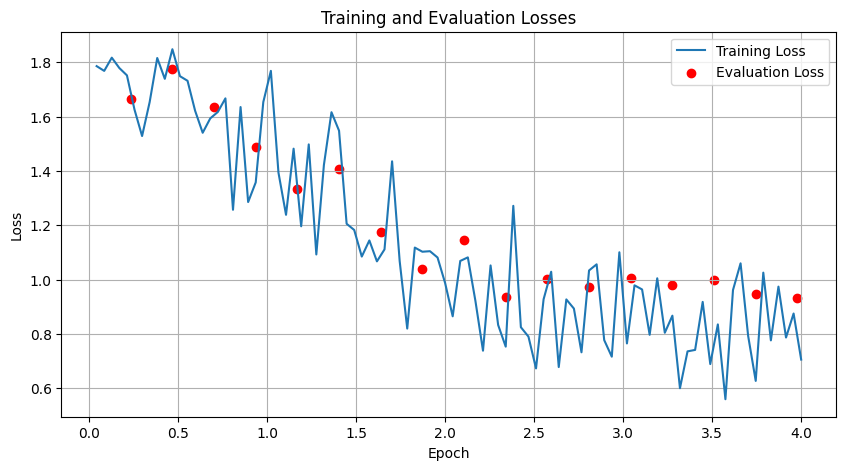

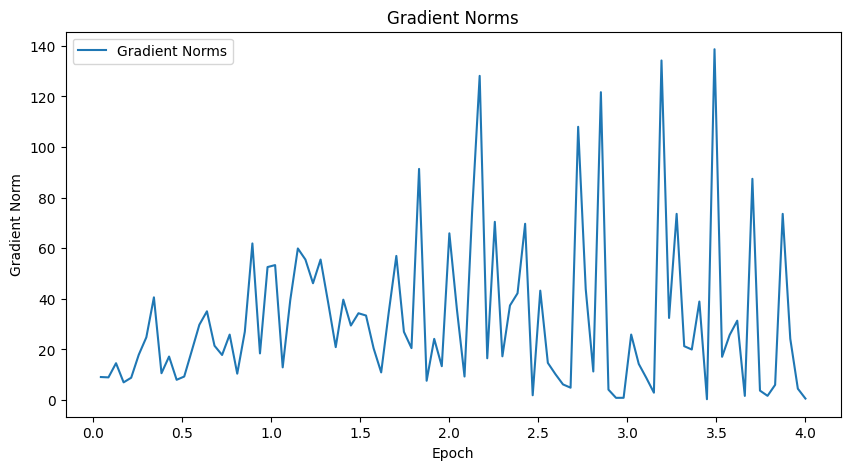

<Figure size 640x480 with 0 Axes>

In [ ]:
import torch
import matplotlib.pyplot as plt 

import os
STORAGE_DIR = os.getenv("STORAGE_DIR", "/media/discoexterno/leon")

def plot_training_metrics():

    # Load saved log history from the HF Trainer.
    # This file should contain a list of dictionaries with logged metrics.
    exp_dir = "legal_ir/results/test_py"
    log_history = torch.load(os.path.join(STORAGE_DIR, exp_dir, "training_metrics_hf.pth"))

    gradient_accumulation_steps = 4

    # Initialize lists to store metrics
    train_losses = []
    eval_losses = []
    grad_norms = []
    train_epochs = []
    eval_epochs = []

    # Iterate over each log entry and extract the metrics.
    for entry in log_history:
        # Check if a training loss is logged.
        if "loss" in entry:
            train_losses.append(entry["loss"] / gradient_accumulation_steps)
            train_epochs.append(entry["epoch"])
        # Check if an evaluation loss is logged.
        if "eval_loss" in entry:
            eval_losses.append(entry["eval_loss"])
            eval_epochs.append(entry["epoch"])
        # Check if a gradient norm is logged.
        if "grad_norm" in entry:
            grad_norms.append(entry["grad_norm"])

    print(grad_norms)
        
    # Plot training losses and evaluation losses in one plot.
    plt.figure(figsize=(10, 5))
    plt.plot(train_epochs, train_losses, label="Training Loss")
    # plot eval loss with dots scatter
    plt.scatter(eval_epochs, eval_losses, label="Evaluation Loss", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Losses")
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(STORAGE_DIR, exp_dir, "training_eval_losses.png"))

    # Plot gradient norms in a separate plot.
    plt.figure(figsize=(10, 5))
    plt.plot(train_epochs, grad_norms, label="Gradient Norms")
    plt.xlabel("Epoch")
    plt.ylabel("Gradient Norm")
    plt.title("Gradient Norms")
    plt.legend()
    plt.show()
    plt.savefig(os.path.join(STORAGE_DIR, exp_dir, "grad_norms.png"))


if __name__ == "__main__":
    plot_training_metrics()

## Analyse tokenized sequence lengths

In [9]:
# add ..utils.train_utils to the sys.path
import sys
sys.path.append("..")
print("Executable", sys.executable)

from unsloth import FastLanguageModel
from utils.train_utils import (
    get_msmarco_queries,
    get_msmarco_passages,
    get_msmarco_hard_negatives,
    tokenize_train_ds_msmarco,
    tokenize_test_ds_msmarco
)

qid_to_query = get_msmarco_queries()
pid_to_passage = get_msmarco_passages()
num_negs = 5
print("Training on MS MARCO dataset...")
negs_ds = get_msmarco_hard_negatives(num_negs, reload=True)
negs_ds = negs_ds.select(range(100_000))

# split negs_ds into train and eval sets with a 90/10 ratio
split = negs_ds.train_test_split(test_size=0.1, seed=42)
train_ds = split["train"]
test_ds = split["test"]

model, tokenizer = FastLanguageModel.from_pretrained(
    # Can select any from the below:
    # "unsloth/Qwen2.5-0.5B", "unsloth/Qwen2.5-1.5B", "unsloth/Qwen2.5-3B"
    # "unsloth/Qwen2.5-14B",  "unsloth/Qwen2.5-32B",  "unsloth/Qwen2.5-72B",
    # And also all Instruct versions and Math. Coding verisons!
    model_name = "unsloth/Llama-3.2-1B-Instruct",
    max_seq_length = 512,
    dtype = "bf16",
    load_in_4bit = False,
    # device_map="cuda:1",
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

# Apply tokenization to the dataset
train_ds = tokenize_train_ds_msmarco(tokenizer, train_ds, qid_to_query, pid_to_passage, num_negs, reuse=False)
test_ds = tokenize_test_ds_msmarco(tokenizer, test_ds, qid_to_query, pid_to_passage, num_negs, reuse=False)

Executable /home/leon/tesis/Environments/IR_env/bin/python
Loading MS MARCO queries...Done
Loading MS MARCO passages...Done
Training on MS MARCO dataset...
Loading hard negatives...Done
==((====))==  Unsloth 2025.2.9: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    GPU: NVIDIA RTX A5000. Max memory: 23.679 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Tokenizing train dataset...Done
Tokenizing test dataset...Done


100%|██████████| 90000/90000 [00:00<00:00, 185251.78it/s]


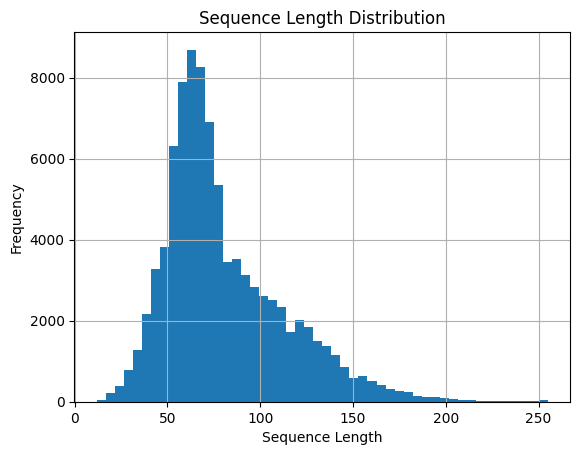

In [10]:
import matplotlib.pyplot as plt
from tqdm import tqdm

seq_lengths = []
# Get the length of each sequence
for example in tqdm(train_ds["doc_input_ids"]):
    eos_position = example.index(tokenizer.eos_token_id)
    seq_lengths.append(eos_position)

plt.hist(seq_lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Sequence Length Distribution")
plt.grid()
plt.show()

# SOLUTION: max seq len of 128 for passages should be sufficient for Llama!

100%|██████████| 90000/90000 [00:00<00:00, 237219.48it/s]


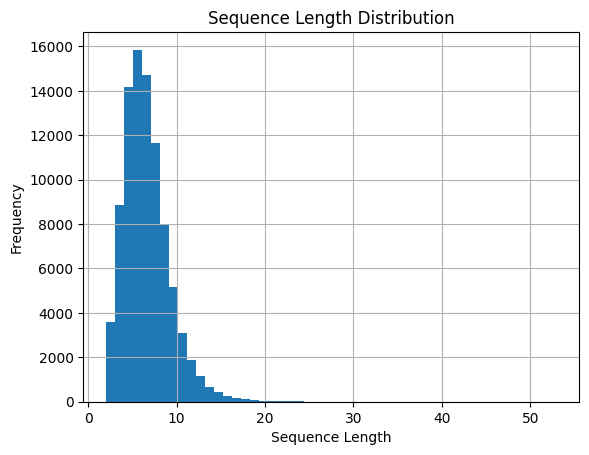

In [8]:
import matplotlib.pyplot as plt
from tqdm import tqdm

seq_lengths = []
# Get the length of each sequence
for example in tqdm(train_ds["query_input_ids"]):
    eos_position = example.index(tokenizer.eos_token_id)
    seq_lengths.append(eos_position)

plt.hist(seq_lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Sequence Length Distribution")
plt.grid()
plt.show()

# SOLUTION: max seq len of 20 for passages should be sufficient for Llama!

## Analyze Annotations

In [ ]:
import json
input_file = "../annotations1.json"

with open(input_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

13, 14, 17, 20, 21, 23, 25, 27, 28, 30, Total annotations: 1420


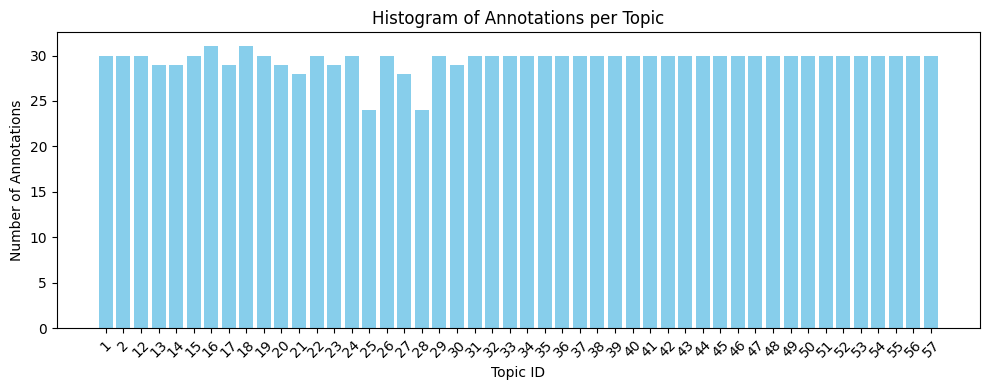

In [6]:
import json
from collections import Counter
import matplotlib.pyplot as plt


def plot_topic_histogram(json_file: str) -> None:
    """
    Reads JSON data from a file, counts the number of annotations for each topic,
    and displays a histogram.

    Parameters
    ----------
    json_file : str
        The path to the JSON file containing the annotation data.

    Returns
    -------
    None
        This function displays a histogram chart. It does not return any value.

    Raises
    ------
    Exception
        Propagates any exception raised during the file reading process.
    """
    try:
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error reading the JSON file: {e}")
        raise

    # Extract the list of annotation entries
    annotations = data.get("groundtruths", {}).get("labels_ground_truths", [])
    topic_counts = Counter()

    # Count annotations for each topic. If there are multiple labels per entry,
    # count each label separately.
    for entry in annotations:
        topic_id = entry.get("topic_id").split(":")[0]
        if topic_id:
            count = len(entry.get("labels", []))
            topic_counts[topic_id] += count

    for topic_id, count in topic_counts.items():
        if count < 30:
            print(topic_id, end=", ")

    # sort topic_counts by topic_id
    topic_counts = dict(sorted(topic_counts.items(), key=lambda x: int(x[0])))

    # Prepare data for the histogram
    topics = list(topic_counts.keys())
    counts = list(topic_counts.values())

    print("Total annotations:", sum(counts))

    # Create the histogram (bar chart)
    plt.figure(figsize=(10, 4))
    plt.bar(topics, counts, color="skyblue")
    plt.xlabel("Topic ID")
    plt.ylabel("Number of Annotations")
    plt.title("Histogram of Annotations per Topic")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 3, 4, 5, 6, 7, 8, 9, 10, 11
input_file = "../annotations1.json"
plot_topic_histogram(input_file)

Error Analysis

{'89': {'map': 0.018103708278876134, 'recip_rank': 0.00909090909090909, 'recall_10': 0.0, 'recall_100': 0.0, 'recall_1000': 0.6071428571428571, 'ndcg': 0.34873208527684774, 'ndcg_cut_10': 0.0}, '117': {'map': 0.0015082956259426848, 'recip_rank': 0.0015082956259426848, 'recall_10': 0.0, 'recall_100': 0.0, 'recall_1000': 1.0, 'ndcg': 0.10666621802745085, 'ndcg_cut_10': 0.0}, '125': {'map': 0.007094634128298538, 'recip_rank': 0.01282051282051282, 'recall_10': 0.0, 'recall_100': 0.03225806451612903, 'recall_1000': 0.22580645161290322, 'ndcg': 0.31333106711513853, 'ndcg_cut_10': 0.0}, '86': {'map': 0.0011303724426352203, 'recip_rank': 0.0015082956259426848, 'recall_10': 0.0, 'recall_100': 0.0, 'recall_1000': 0.3333333333333333, 'ndcg': 0.13259564489170103, 'ndcg_cut_10': 0.0}, '119': {'map': 0.017857142857142856, 'recip_rank': 0.017857142857142856, 'recall_10': 0.0, 'recall_100': 1.0, 'recall_1000': 1.0, 'ndcg': 0.17144160057391347, 'ndcg_cut_10': 0.0}, '103': {'map': 0.0005499118930839806,

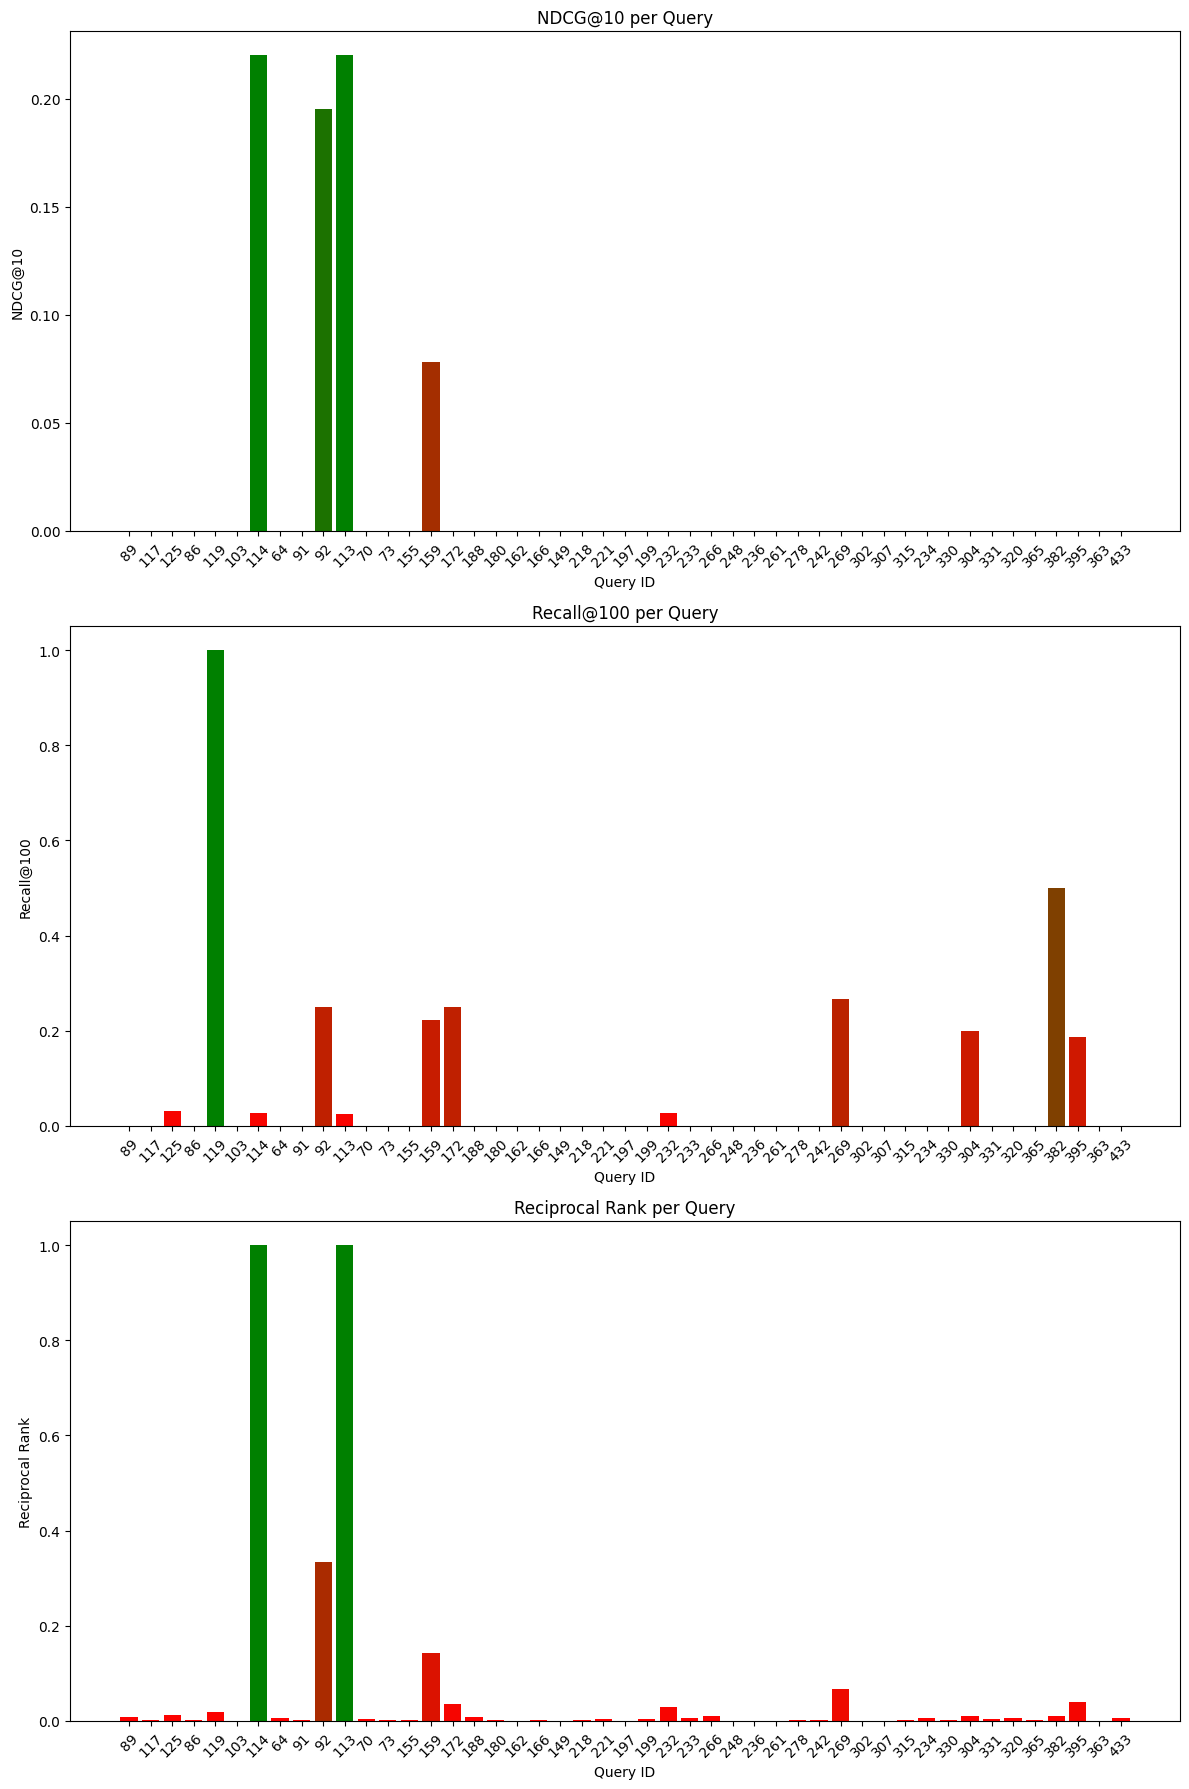

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize


# with open("../metrics_per_query_bm25.pkl", "rb") as f:
#     metrics_bm25 = pickle.load(f)
with open("../metrics_per_query.pkl", "rb") as f:
    metrics_bm25 = pickle.load(f)

print(metrics_bm25)

# Convert dictionary to DataFrame (queries as rows, metrics_bm25 as columns)
df = pd.DataFrame(metrics_bm25).T
df.index.name = "Query ID"
df.reset_index(inplace=True)

# Create a custom colormap from blue to yellow
cmap = LinearSegmentedColormap.from_list("blue_yellow", ["red", "green"])

# Create subplots: one chart per metric
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Chart 1: NDCG@10 (using ndcg_cut_10)
values = df["ndcg_cut_10"]
norm = Normalize(vmin=values.min(), vmax=values.max())
colors = [cmap(norm(val)) for val in values]
axs[0].bar(df["Query ID"], values, color=colors)
axs[0].set_title("NDCG@10 per Query")
axs[0].set_xlabel("Query ID")
axs[0].set_ylabel("NDCG@10")
axs[0].tick_params(axis="x", rotation=45)

# Chart 2: Recall@100
values = df["recall_100"]
norm = Normalize(vmin=values.min(), vmax=values.max())
colors = [cmap(norm(val)) for val in values]
axs[1].bar(df["Query ID"], values, color=colors)
axs[1].set_title("Recall@100 per Query")
axs[1].set_xlabel("Query ID")
axs[1].set_ylabel("Recall@100")
axs[1].tick_params(axis="x", rotation=45)

# Chart 3: Reciprocal Rank
values = df["recip_rank"]
norm = Normalize(vmin=values.min(), vmax=values.max())
colors = [cmap(norm(val)) for val in values]
axs[2].bar(df["Query ID"], values, color=colors)
axs[2].set_title("Reciprocal Rank per Query")
axs[2].set_xlabel("Query ID")
axs[2].set_ylabel("Reciprocal Rank")
axs[2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# 1) Tell Matplotlib to use a serif font family...
mpl.rcParams["font.family"] = "serif"

# 2) …and to pick Times New Roman (or “Times” on some systems):
mpl.rcParams["font.serif"] = ["Times New Roman", "Times", "Linux Libertine"]

# 3) (Optional) if you’re saving to PDF/PS and want real embedded Type-1 fonts:
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"]  = 42

# 4) (Optional) to let LaTeX handle all the text rendering—exact match to your .tex:
mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = r"\usepackage{newtxtext,newtxmath}"

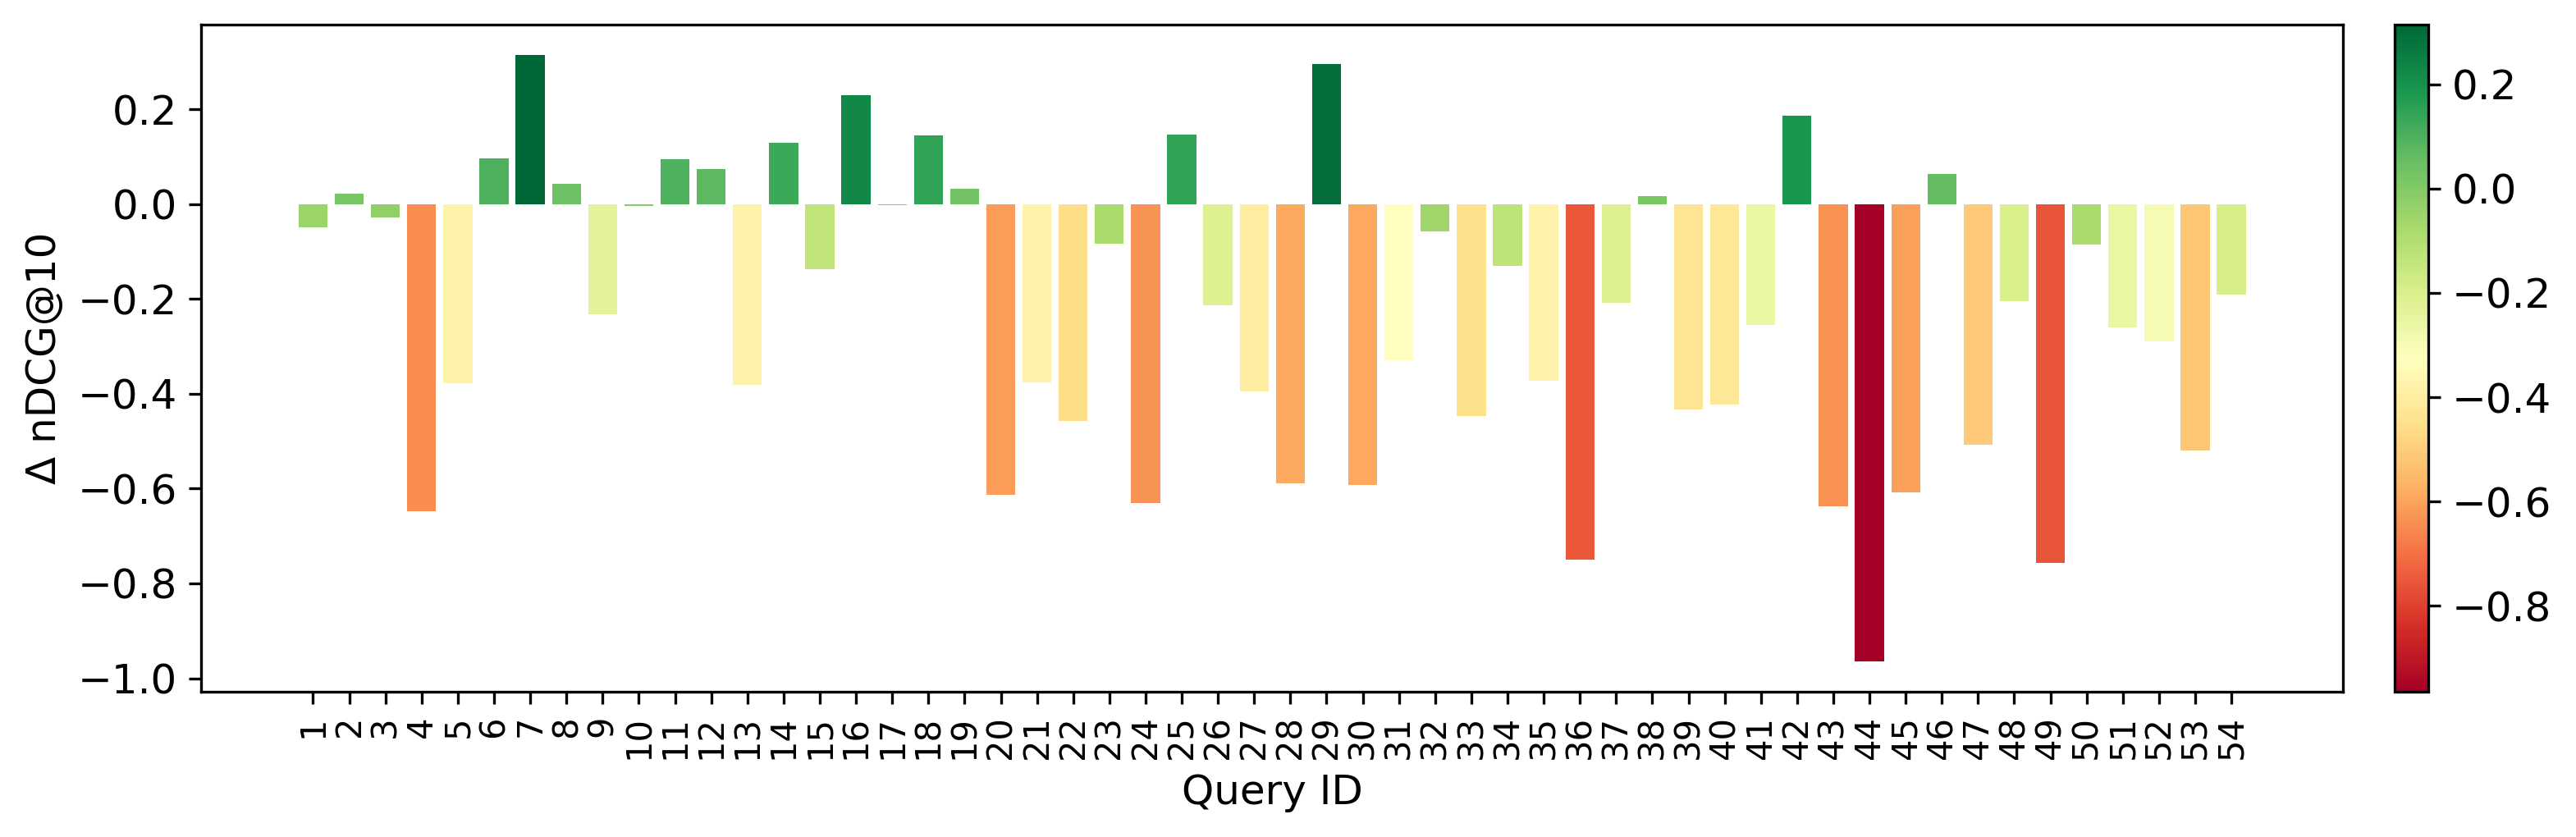

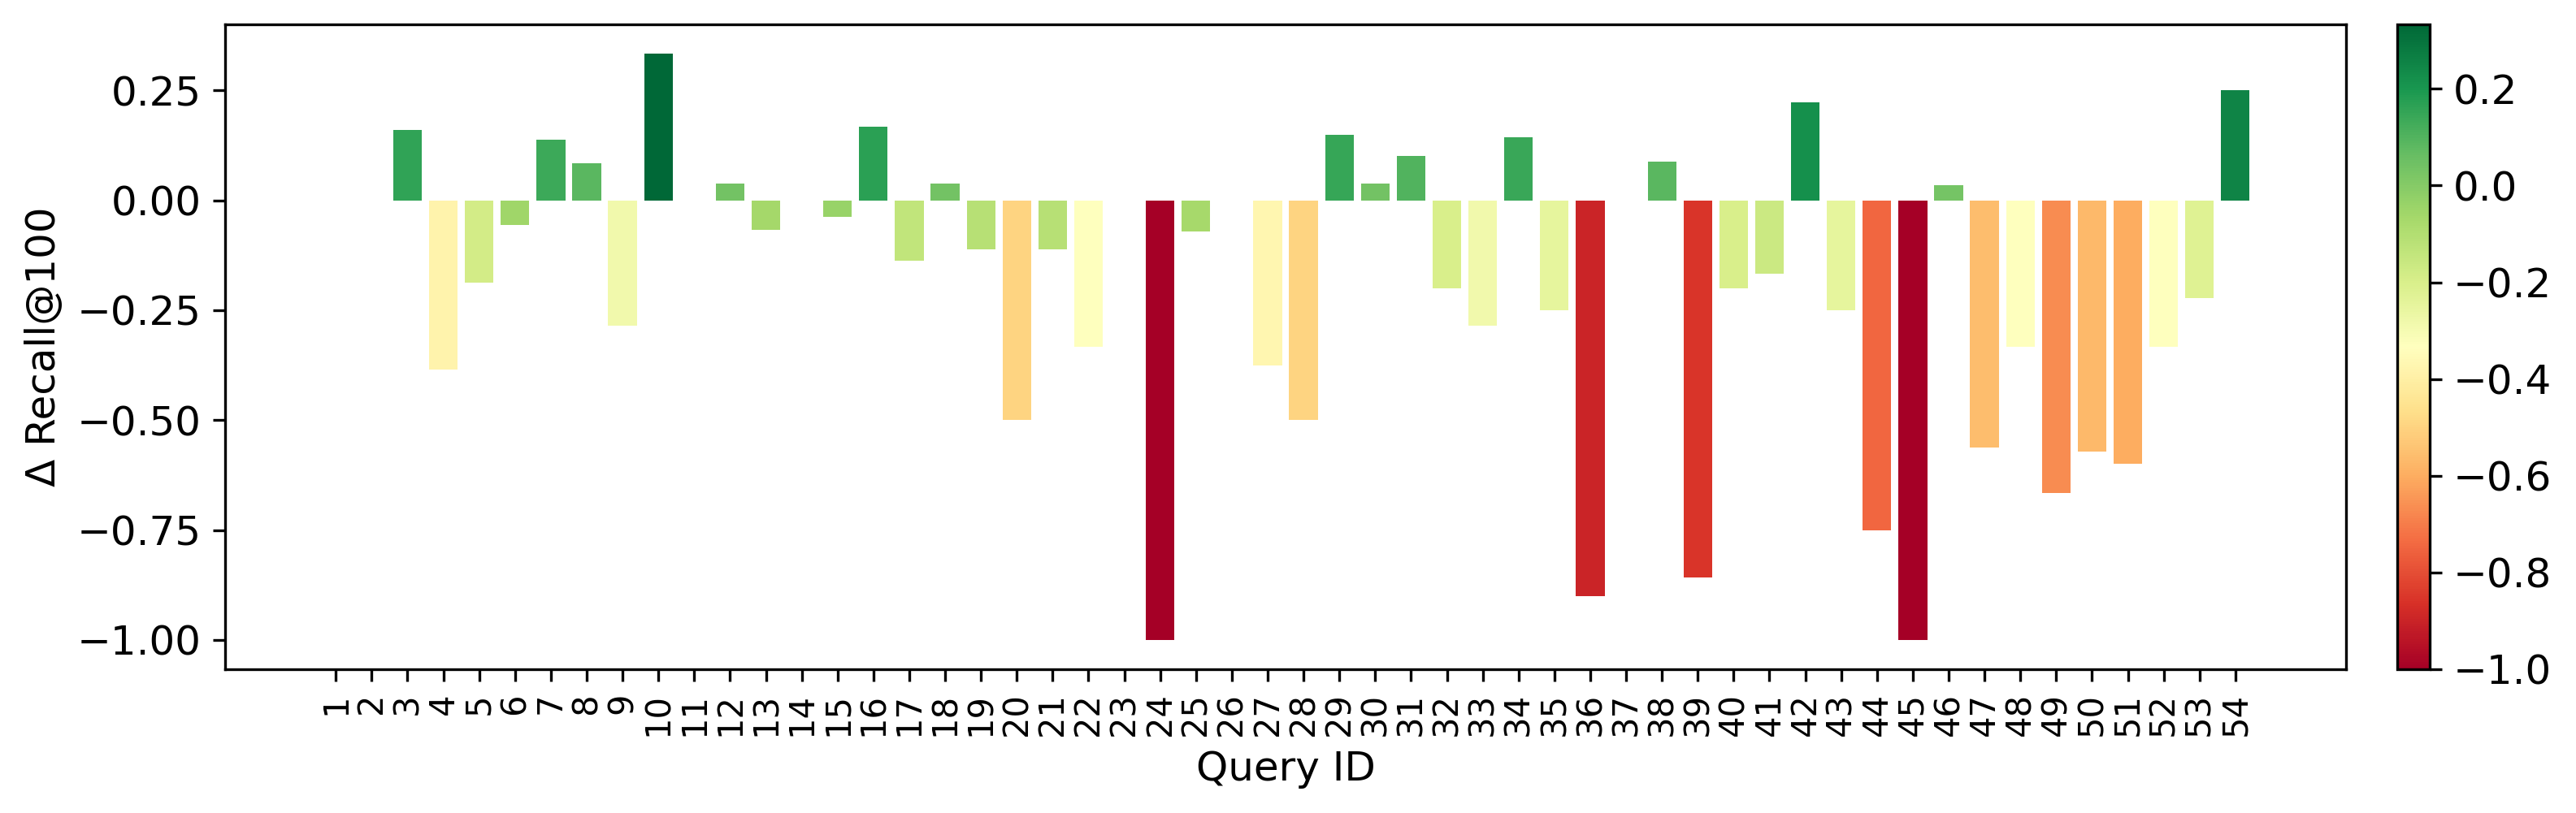

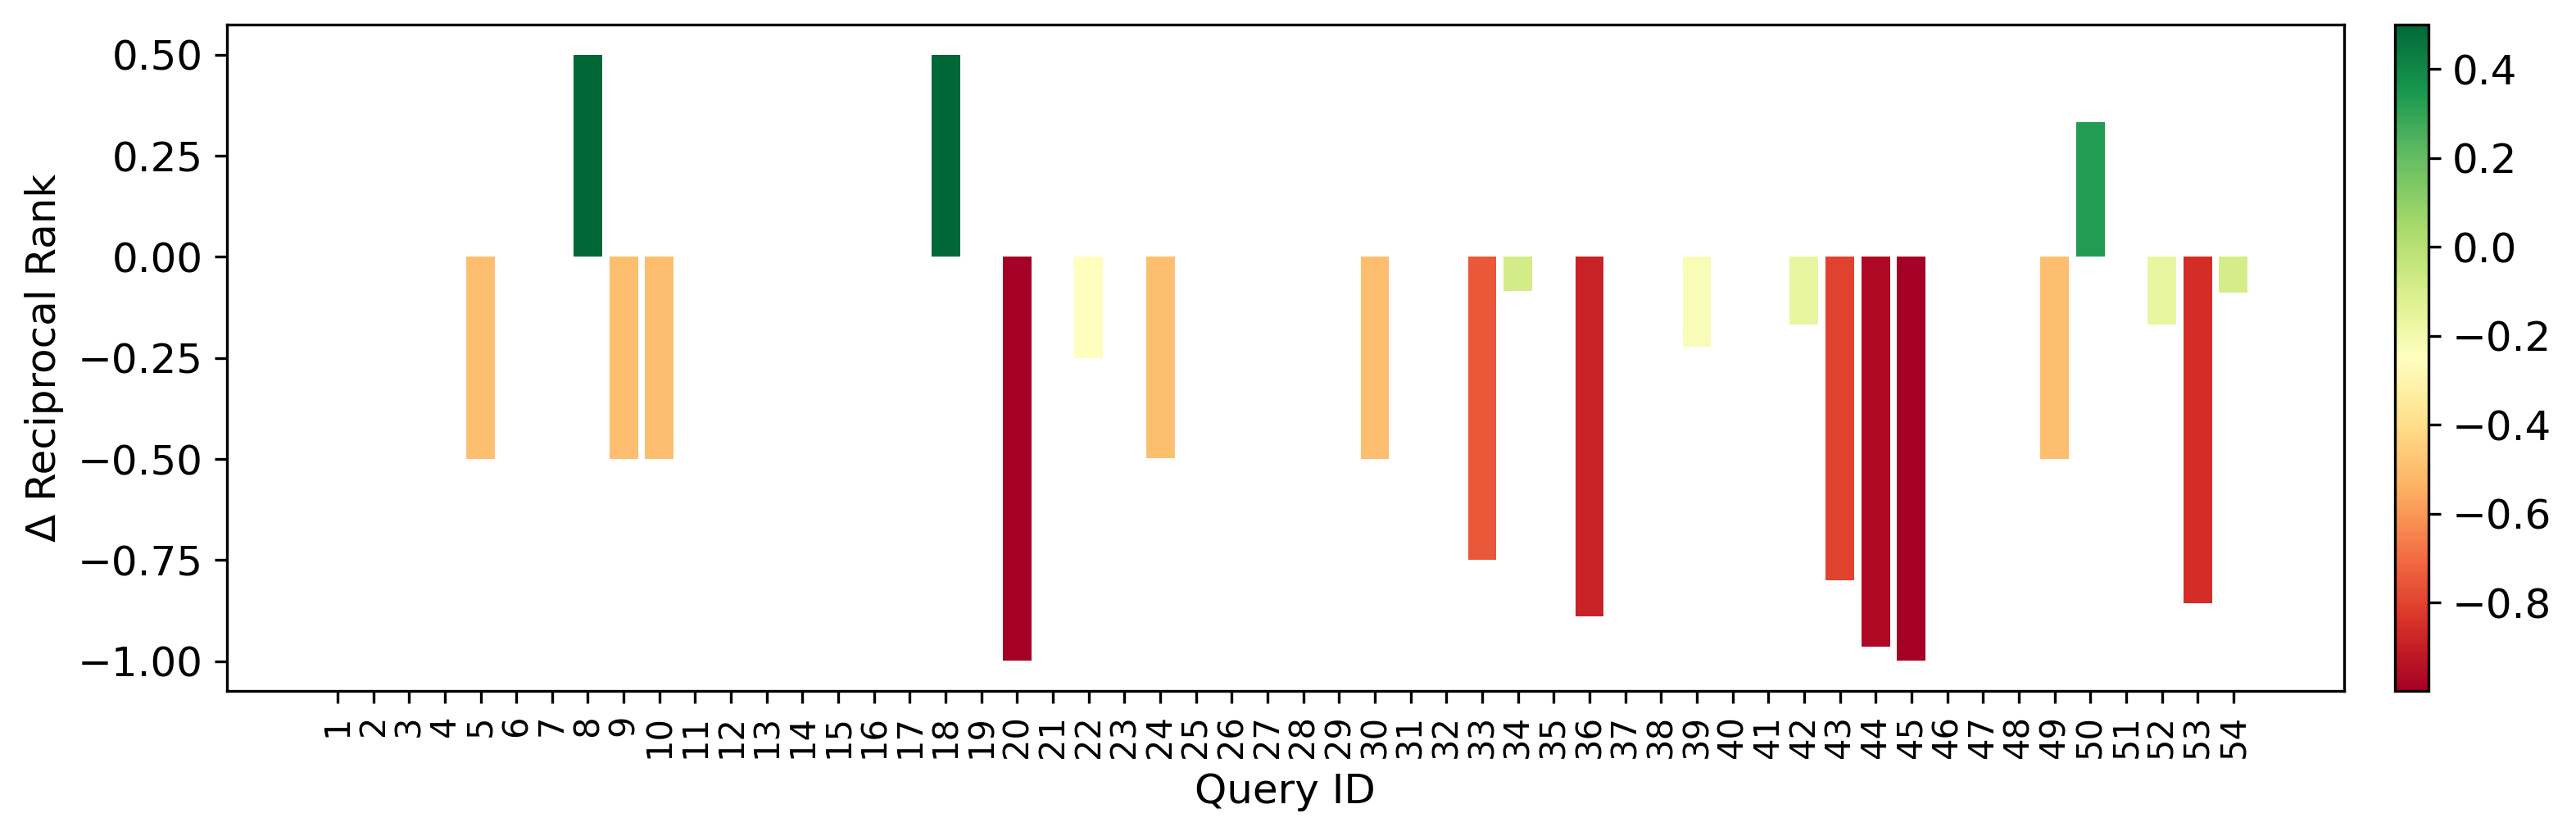

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import pickle

# --- load your precomputed per-query metrics ---
with open("../metrics_per_query_bm25.pkl", "rb") as f:
    metrics_bm25 = pickle.load(f)
with open("../metrics_per_query_bge.pkl", "rb") as f:
    metrics_transformer = pickle.load(f)

# DataFrames indexed by query ID
df_bm25        = pd.DataFrame(metrics_bm25).T
df_transformer = pd.DataFrame(metrics_transformer).T
df_diff        = df_transformer - df_bm25

def pretty_name(metric):
    return {
        "ndcg_cut_10": "nDCG@10",
        "recall_100":  "Recall@100",
        "recip_rank":  "Reciprocal Rank",
    }.get(metric, metric)

def plot_diff_bar(metric_name, df_diff):
    """
    Bar chart of (Transformer − BM25) per query, with a diverging colormap.
    """
    # compute
    values = df_diff[metric_name].values
    queries = df_diff.index.astype(str)

    # colormap: red for negative, green for positive
    cmap = plt.get_cmap("RdYlGn")
    norm = Normalize(vmin=values.min(), vmax=values.max())
    colors = cmap(norm(values))

    # figure
    fig, ax = plt.subplots(figsize=(11.5, 3.5), dpi=300)
    x = np.arange(len(values))

    bars = ax.bar(x, values, color=colors, width=0.8)

    # axes & title
    ylabel = f"Δ {pretty_name(metric_name)}"
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel("Query ID", fontsize=12)
    # ax.set_title(f"BGE – BM25: {pretty_name(metric_name)} Difference", fontsize=12)

    # ticks
    ax.set_xticks(x)
    ax.set_xticklabels(queries, rotation=90, fontsize=10)
    ax.tick_params(axis="y", labelsize=12)

    # colorbar
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", pad=0.02)
    # cbar.set_label(ylabel, fontsize=12)
    cbar.ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.show()

# plot


# Plot for NDCG@10 (using ndcg_cut_10)
plot_diff_bar("ndcg_cut_10", df_diff)

# Plot for Recall@100
plot_diff_bar("recall_100", df_diff)

# Plot for Reciprocal Rank
plot_diff_bar("recip_rank", df_diff)
